In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3,lifelines

cs224 
last updated: 2020-03-21 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8
lifelines 0.24.2


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 41
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)

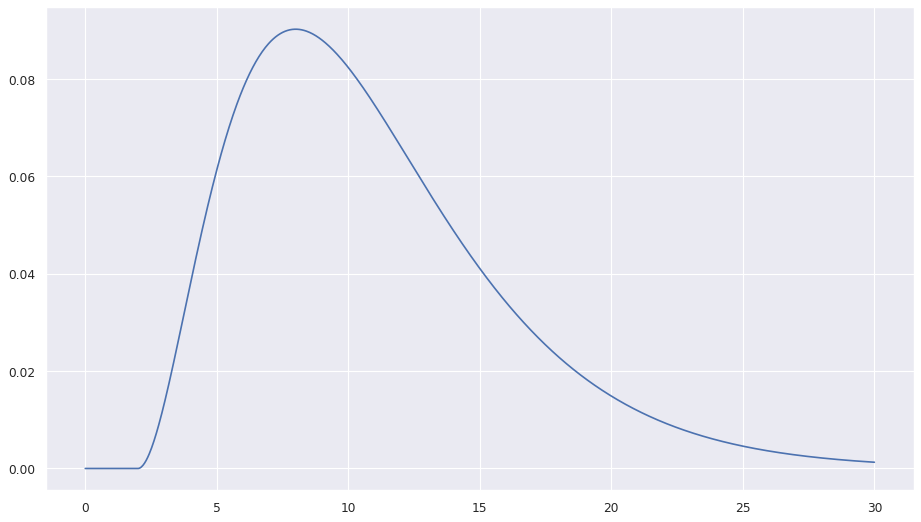

In [5]:
x = np.linspace(0.0,30.0,1000)
gamma_loc   = 2.0
gamma_k     = 3.0
gamme_theta = 3.0
y = stats.gamma(gamma_k, loc=gamma_loc, scale=gamme_theta).pdf(x)
fig=plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.plot(x,y)

In [6]:
china_mortality_analysis = covid19.MortalityAnalysis('China')

In [7]:
china_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-16,81033,67910,3217,30,893,14
2020-03-17,81058,68798,3230,25,888,13
2020-03-18,81102,69755,3241,44,957,11
2020-03-19,81156,70535,3249,54,780,8
2020-03-20,81250,71266,3253,94,731,4


In [8]:
# china_mortality_analysis.df_lifelines_individual.observed_death.sum()

In [9]:
# china_mortality_analysis.df.head()

In [10]:
# china_mortality_analysis.df.tail()

In [11]:
china_mortality_analysis.fit()

In [12]:
# china_mortality_analysis.wbf.print_summary()

# expected_life_time = china_mortality_analysis.wbf.lambda_ * scipy.special.gamma(1 + 1 / china_mortality_analysis.wbf.rho_)
# expected_life_time/365

In [13]:
china_mortality_analysis.death_rate()

(4.02, 3.89, 4.16)

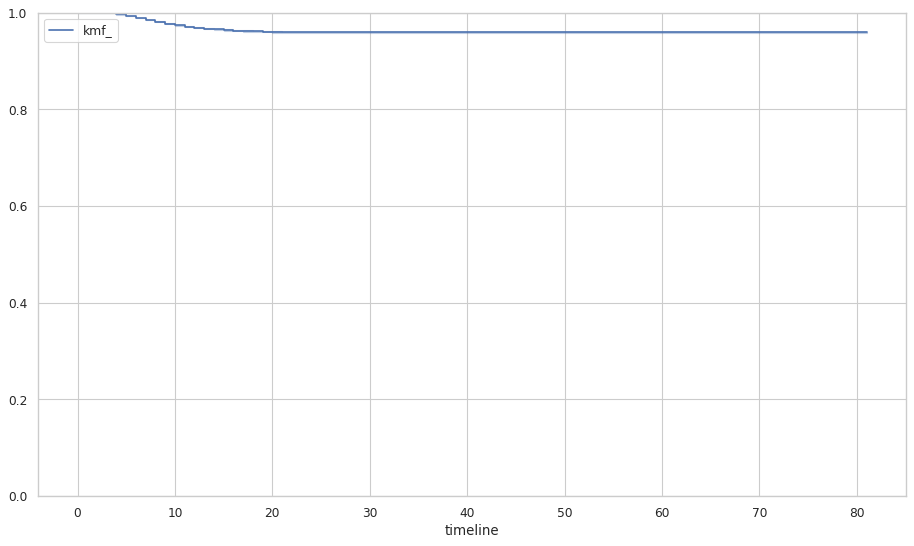

In [14]:
china_mortality_analysis.plot()

(2.28, 1.67, 3.12)


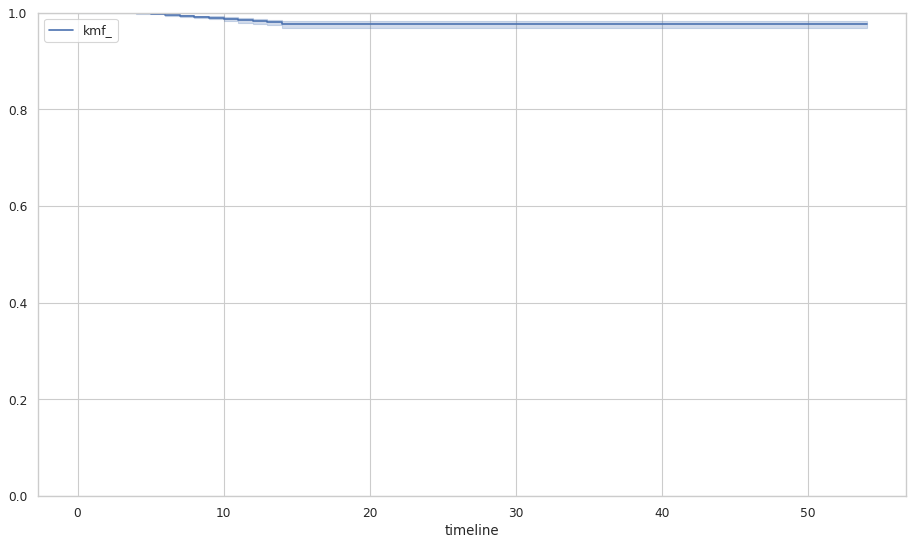

In [15]:
germany_mortality_analysis = covid19.MortalityAnalysis('Germany')
germany_mortality_analysis.fit()
print(germany_mortality_analysis.death_rate())
germany_mortality_analysis.plot()

In [16]:
germany_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-16,7272,67,17,1459,21,4
2020-03-17,9360,71,26,2088,4,9
2020-03-18,12327,105,28,2967,34,2
2020-03-19,15320,115,44,2993,10,16
2020-03-20,19848,180,68,4528,65,24


(1.42, 1.17, 1.73)
(1.27, 1.04, 1.54)
9699


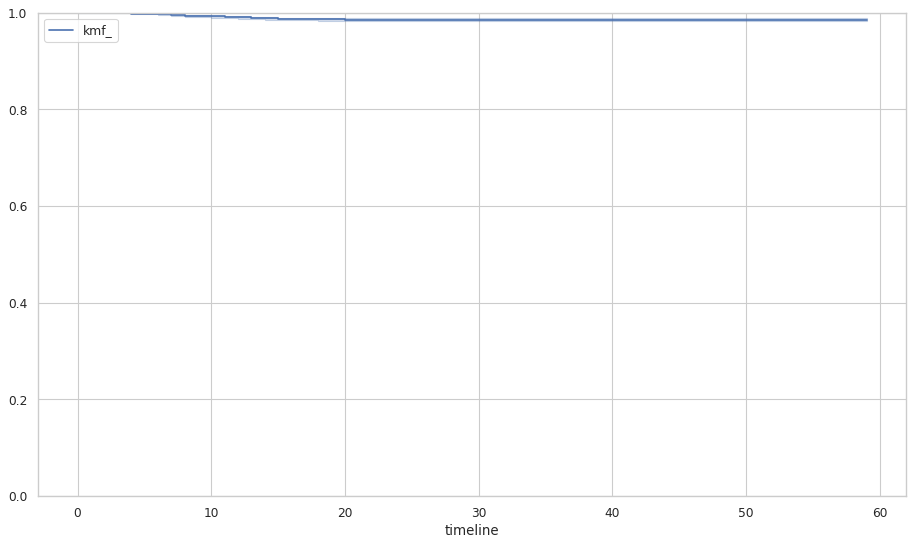

In [17]:
south_korea_name = 'Korea, South'
south_korea_mortality_analysis = covid19.MortalityAnalysis(south_korea_name)
south_korea_mortality_analysis.fit()
south_korea_mortality_analysis2 = covid19.MortalityAnalysis(south_korea_name, first_date=pd.to_datetime('2020-02-20'), init_add=900)
south_korea_mortality_analysis2.fit()
print(south_korea_mortality_analysis.death_rate())
print(south_korea_mortality_analysis2.death_rate())
print(south_korea_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
south_korea_mortality_analysis.plot()

In [18]:
south_korea_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-16,8320,1137,75,84,0,0
2020-03-17,8413,1540,84,93,403,9
2020-03-18,8565,1947,91,152,407,7
2020-03-19,8652,2233,94,87,286,3
2020-03-20,8799,2233,104,147,0,10


In [19]:
# south_korea_mortality_analysis.prepend_df

(14.72, 12.9, 16.76)
(3.04, 2.71, 3.42)
52448


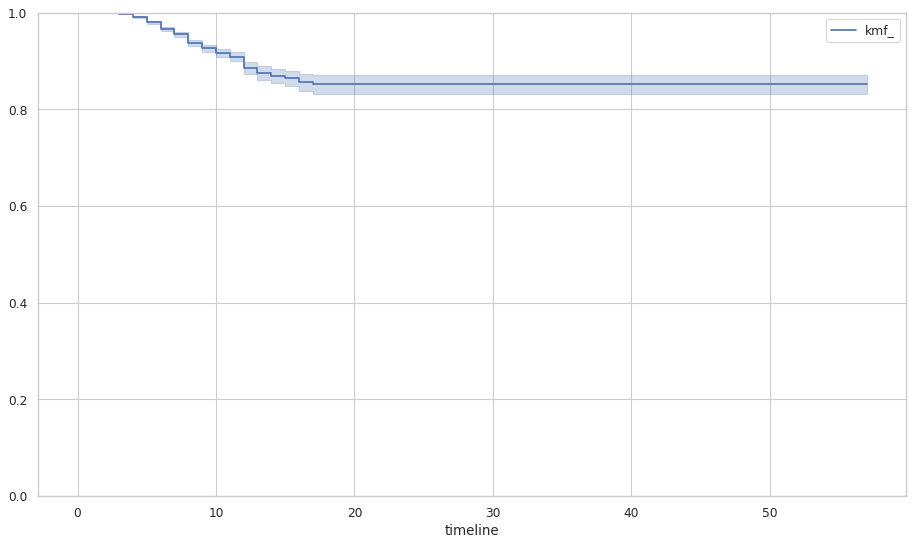

In [20]:
france_mortality_analysis = covid19.MortalityAnalysis('France')
france_mortality_analysis.fit()
france_mortality_analysis2 = covid19.MortalityAnalysis('France', first_date=pd.to_datetime('2020-02-15'), init_add=500, mult=4)
france_mortality_analysis2.fit()
print(france_mortality_analysis.death_rate())
print(france_mortality_analysis2.death_rate())
print(france_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
france_mortality_analysis.plot()

In [21]:
france_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-16,6655,12,148,1232,0,21
2020-03-17,7730,12,175,1075,0,27
2020-03-18,9134,12,264,1404,0,89
2020-03-19,11010,12,372,1876,0,108
2020-03-20,12612,1587,450,1602,1575,78


(24.13, 21.89, 26.55)
(3.42, 3.15, 3.72)
156597


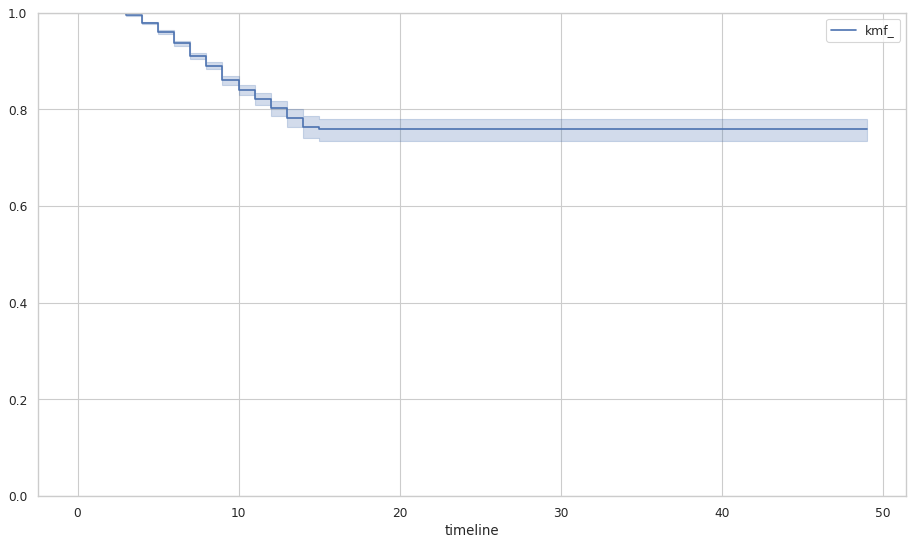

In [22]:
spain_mortality_analysis = covid19.MortalityAnalysis('Spain')
spain_mortality_analysis.fit()
spain_mortality_analysis2 = covid19.MortalityAnalysis('Spain', first_date=pd.to_datetime('2020-03-03'), init_add=800, mult=7.0)
spain_mortality_analysis2.fit()
print(spain_mortality_analysis.death_rate())
print(spain_mortality_analysis2.death_rate())
print(spain_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
spain_mortality_analysis.plot()

In [23]:
spain_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-16,9942,530,342,2098,13,50
2020-03-17,11826,1028,533,1884,498,191
2020-03-18,14769,1081,638,2943,53,105
2020-03-19,18077,1107,833,3308,26,195
2020-03-20,21571,1588,1093,3494,481,260


(24.82, 20.65, 29.66)
(3.2, 2.73, 3.75)
19256


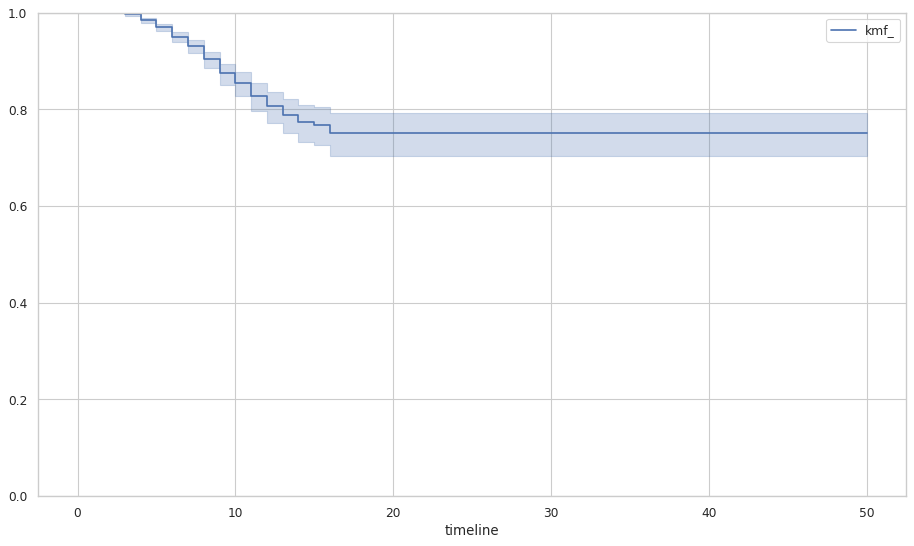

In [24]:
uk_name = 'United Kingdom'
uk_mortality_analysis = covid19.MortalityAnalysis(uk_name)
uk_mortality_analysis.fit()
uk_mortality_analysis2 = covid19.MortalityAnalysis(uk_name, first_date=pd.to_datetime('2020-03-05'), init_add=800, mult=4.0)
uk_mortality_analysis2.fit()
print(uk_mortality_analysis.death_rate())
print(uk_mortality_analysis2.death_rate())
print(uk_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
uk_mortality_analysis.plot()

In [25]:
uk_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-16,1553,53,56,181,35,21
2020-03-17,1960,66,72,407,13,16
2020-03-18,2644,67,104,684,1,32
2020-03-19,3269,67,144,625,0,40
2020-03-20,4014,67,178,745,0,34


In [26]:
# pd.options.mode.chained_assignment = "raise"

(8.83, 7.65, 10.19)
(2.88, 2.44, 3.39)
80484


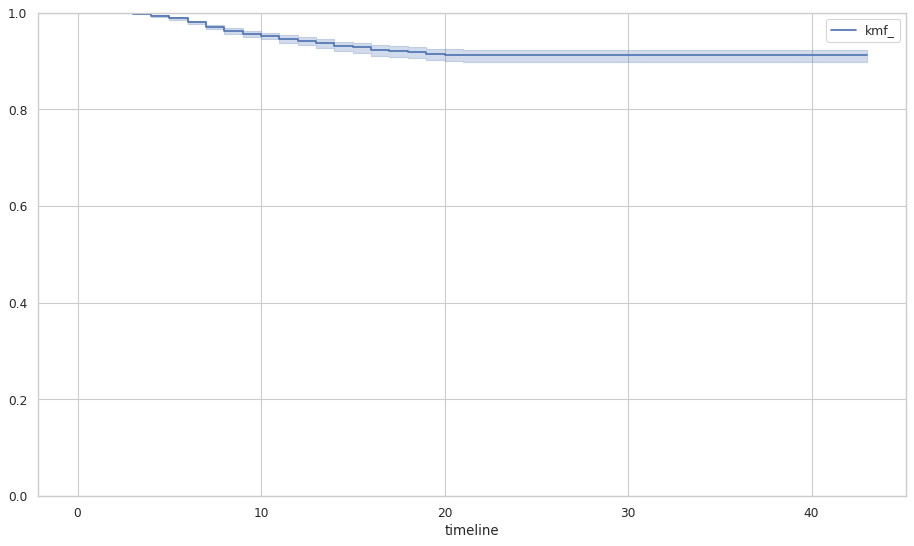

In [27]:
us_mortality_analysis = covid19.MortalityAnalysis('US', first_date=pd.to_datetime('2020-02-29'), init_add=950)
us_mortality_analysis.fit()
us_mortality_analysis2 = covid19.MortalityAnalysis('US', first_date=pd.to_datetime('2020-02-29'), init_add=450, mult=4.0)
us_mortality_analysis2.fit()
print(us_mortality_analysis.death_rate())
print(us_mortality_analysis2.death_rate())
print(us_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
us_mortality_analysis.plot()

In [28]:
us_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-16,4661,17,85,870,8,20
2020-03-17,6496,17,114,1835,0,29
2020-03-18,9345,106,150,2849,89,36
2020-03-19,14312,121,208,4967,15,58
2020-03-20,19671,147,260,5359,26,52


(26.7, 25.68, 27.75)
(3.46, 3.33, 3.59)
343147


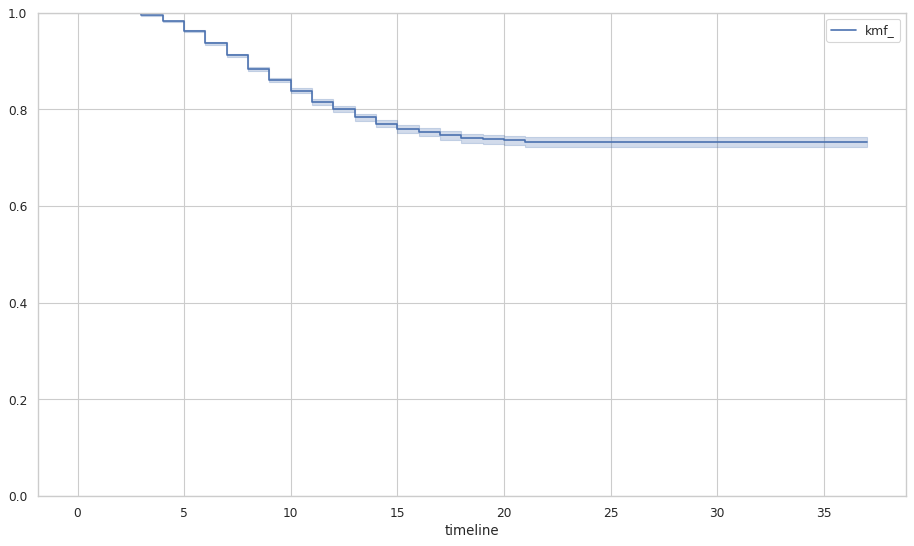

In [29]:
italy_mortality_analysis = covid19.MortalityAnalysis('Italy', first_date=pd.to_datetime('2020-02-21'))
italy_mortality_analysis.fit()
print(italy_mortality_analysis.death_rate())
italy_mortality_analysis2 = covid19.MortalityAnalysis('Italy', first_date=pd.to_datetime('2020-02-21'), init_add=2000, mult=7.0)
italy_mortality_analysis2.fit()
print(italy_mortality_analysis2.death_rate())
print(italy_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
italy_mortality_analysis.plot()

In [30]:
italy_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-03-16,27980,2749,2158,3233,414,349
2020-03-17,31506,2941,2503,3526,192,345
2020-03-18,35713,4025,2978,4207,1084,475
2020-03-19,41035,4440,3405,5322,415,427
2020-03-20,47021,5129,4032,5986,689,627


In [31]:
# italy_mortality_analysis2.prepend_df

In [32]:
import rpy2
print(rpy2.__version__)

2.9.4


In [33]:
from rpy2.rinterface import R_VERSION_BUILD
print(R_VERSION_BUILD)

('3', '6.0', '', 76424)


In [34]:
import IPython.display
import rpy2, rpy2.robjects, rpy2.robjects.pandas2ri, rpy2.rinterface, rpy2.robjects.packages, rpy2.interactive, rpy2.robjects.lib.ggplot2, rpy2.robjects.lib.grdevices
rpy2.robjects.pandas2ri.activate()

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('LexisPlotR',)

# R vector of strings
from rpy2.robjects.vectors import StrVector

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/lib/ggplot2.py:67: UserWarning: This was designed againt ggplot2 version 2.2.1 but you have 3.3.0
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


In [35]:
grdevices = rpy2.robjects.packages.importr('grDevices')
# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

lexis = importr('LexisPlotR')
lexis

rpy2.robjects.packages.Package as a <module 'LexisPlotR'>

In [36]:
lexis_grid = rpy2.robjects.r['lexis.grid']
lexis_lifeline = rpy2.robjects.r['lexis.lifeline']

In [37]:
def plot_lexis(mortality_analysis_instance):
    mylexis = lexis_grid(year_start = 2020, year_end = 2021, age_start = 0, age_end = 1) #  lwd = 0.1

    alpha = 1.0
    ix_present = ~mortality_analysis_instance.df_lifelines_individual.observed_death
    ix_lost    = mortality_analysis_instance.df_lifelines_individual.observed_death
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_present], exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_present], colour = "orange", alpha = alpha, lwd = 0.4)
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_lost]   , exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_lost]   , colour = "blue"  , alpha = alpha, lwd = 0.4, lineends = True)

    with rpy2.robjects.lib.grdevices.render_to_bytesio(grdevices.png, width=1.5*1024, height=1.5*896, res=90) as img:
        rpy2.robjects.r.print(mylexis)   
    IPython.display.display(IPython.display.Image(data=img.getvalue(), format='png', embed=True))

In [38]:
# plot_lexis(italy_mortality_analysis)

In [39]:
# plot_lexis(italy_mortality_analysis2)

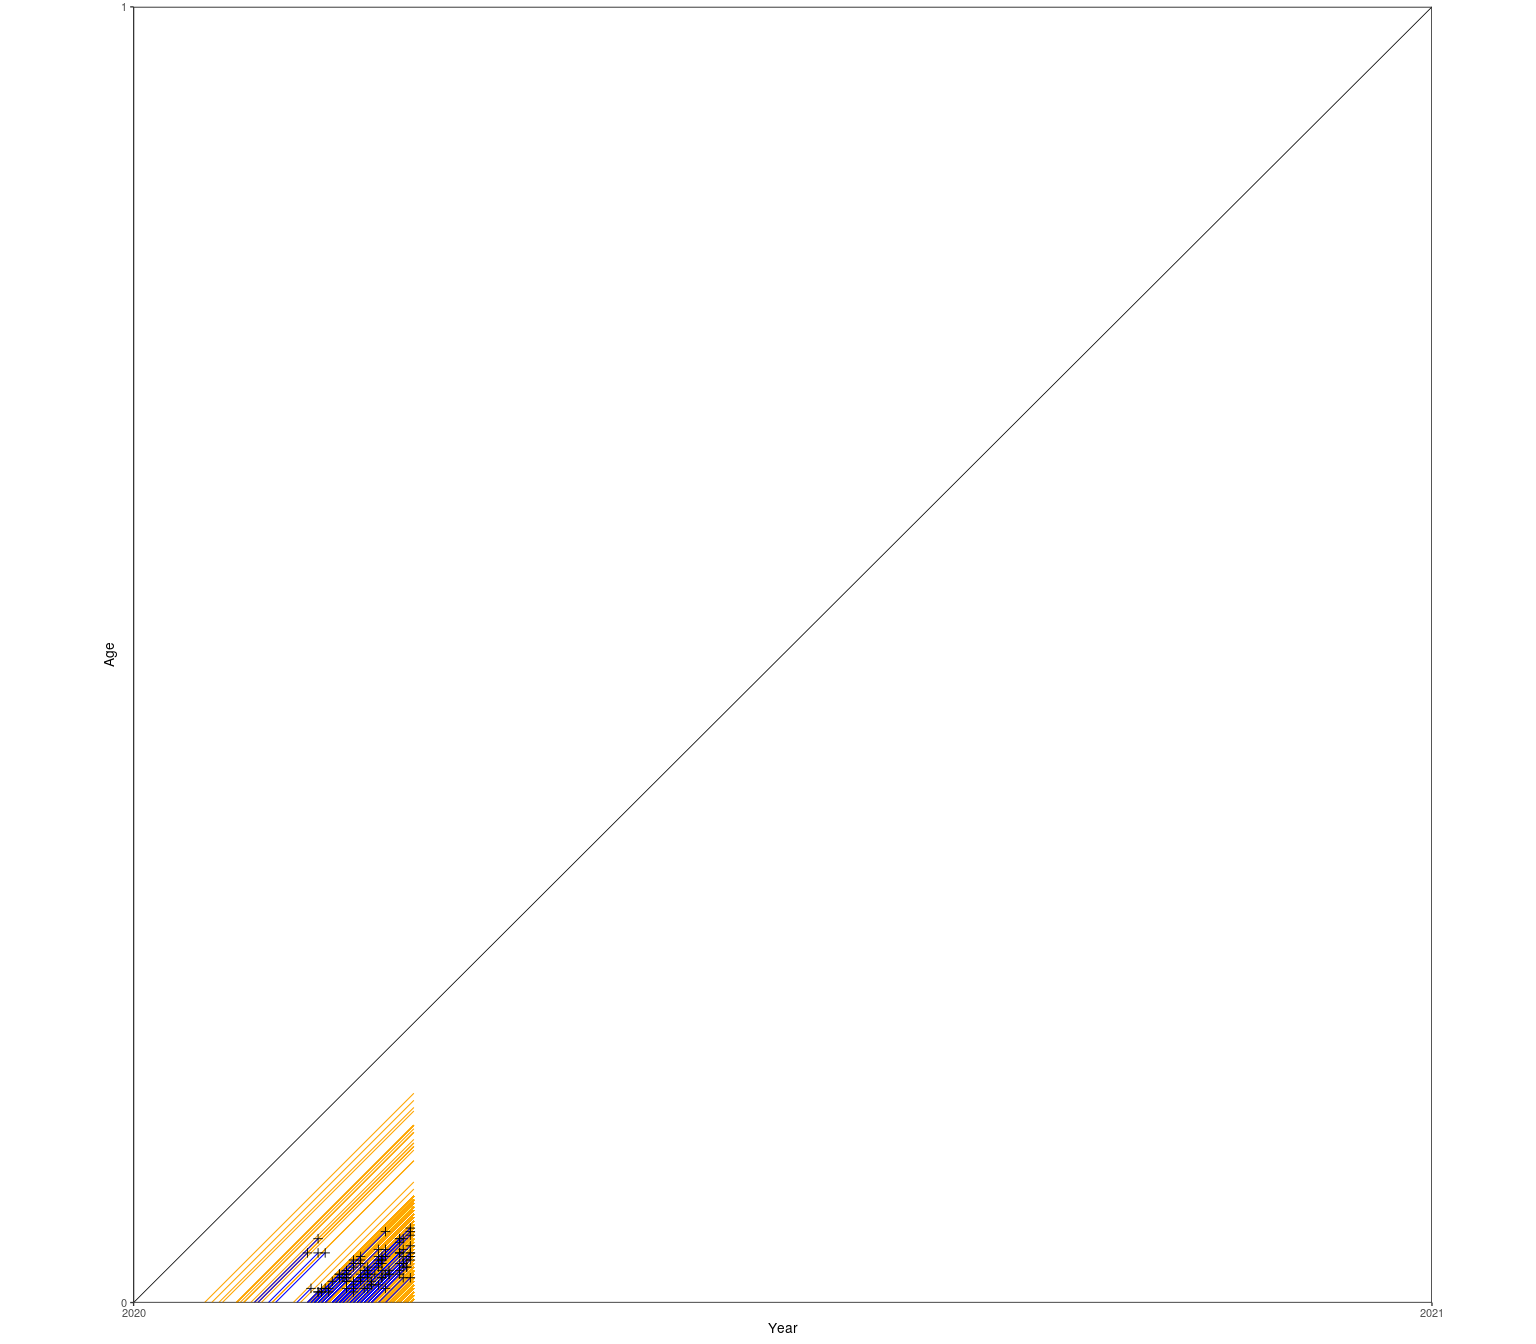

In [40]:
plot_lexis(south_korea_mortality_analysis)